# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, you will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. You will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. You will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, you should start by asking questions you might want to understand about the bike share data. Consider, for example, if you were working for Motivate. What kinds of information would you want to know about in order to make smarter business decisions? If you were a user of the bike-share service, what factors might influence how you would want to use the service?

**Question 1**: Write at least two questions related to bike sharing that you think could be answered by data.

**Answer**: 
             1.Find the places where people uses Bikes frequently for travel ?
             2.Predict the availabilty of Bikes at Places by  the analysis of data ?  
             3.Find Some particular days or time if bikes is used very much?


<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. **However, you do not need to download the data yourself.** The data has already been collected for you in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed for you. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

**Question 2**: However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. Run the first code cell below to load some packages and functions that you'll be using in your analysis. Then, complete the second code cell to print out the first trip recorded from each of the cities (the second line of each data file).



In [15]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
import pprint# display in specific style 
import pandas as pd
import numpy as np

In [17]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html  ##
        trip_reader = csv.DictReader(f_in)
        
        ## Use a function on the DictReader object to read the  ##
        ## first trip from the data file and store it in a variable. ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##

        first_trip=next(trip_reader)
        
        ## Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html##
              
        p = pprint.PrettyPrinter()
        p.pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv']

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip



City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

You will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [18]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
   
    """
    # YOUR CODE HERE 

    if city == 'Chicago': 
        duration = float(datum['tripduration']) / 60
        
    elif city == 'NYC':
        duration = float(datum['tripduration']) / 60
        
    elif city == 'Washington':  # used ELIF instead of ELSE so that conditions  and corresponding data 
        duration = float(datum['Duration (ms)']) / 60000 #should be properly make understandable 
        
    return duration


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [19]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.

    """
      
    if city == 'Chicago':
        date_time = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M') 
        day_of_week=date_time.strftime('%A')
        month,hour = date_time.month, date_time.hour
    
    elif city == 'NYC':
        date_time = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M:%S') 
        day_of_week=date_time.strftime('%A')
        month,hour = date_time.month, date_time.hour
    
    elif city == 'Washington':   ## used ELIF instead of ELSE so that conditions  and corresponding data
        date_time = datetime.strptime(datum['Start date'], '%m/%d/%Y %H:%M') #should be properly make understandable
        day_of_week=date_time.strftime('%A')
        month,hour = date_time.month, date_time.hour
    
    return (month, hour, day_of_week)


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [20]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    # YOUR CODE HERE
    
    if city == 'Chicago': 
        user_type = datum['usertype']
        
    elif city == 'NYC':
        user_type = datum['usertype']
        
    elif city == 'Washington':   # used ELIF instead of ELSE so that conditions  and corresponding data
        if datum['Member Type'] == 'Registered':  #should be properly make understandable 
            user_type = 'Subscriber'  
        else: 
            user_type = 'Customer'
    
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: Now, use the helper functions you wrote above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, you will see an example datafile from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that your output is formatted to be consistent with the example file.

In [21]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## set up csv DictReader object ##
        trip_reader =csv.DictReader(f_in) 

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'],new_point['hour'], new_point['day_of_week'] = time_of_trip(row, city)
            new_point['user_type'] = type_of_user(row, city)

            ## write the processed information to the output file.     ##
            trip_writer.writerow(new_point)
            
            

In [22]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that you have the data collected and wrangled, you're ready to start exploring the data. In this section you will write some code to compute descriptive statistics from the data. You will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**: NYC has highest number of trips.
            NYC has the highest proportion of trips made by subscribers.
            Chicago has the highest proportion of trips made by short-term customers.

In [24]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        sub_pro = (n_subscribers / n_total) * 100 # SUB_PRO is subscribers proportion
        cus_pro = (n_customers / n_total) * 100   # CUS_PRO is customers proportion
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total,sub_pro,cus_pro)

In [26]:
## Modify this and the previous cell to answer Question 4a.##
## the function on the cleaned data files you created from Question 3. ##

data_file = ['./data/Washington-2016-Summary.csv', './data/Chicago-2016-Summary.csv', './data/NYC-2016-Summary.csv']

for datafile in data_file:
    city = datafile.split('-')[0].split('/')[-1]
    print(city)
    print(number_of_trips(datafile))
       

Washington
(51753, 14573, 66326, 78.0282242257938, 21.971775774206193)
Chicago
(54982, 17149, 72131, 76.22520136973007, 23.774798630269924)
NYC
(245896, 30902, 276798, 88.83590199351151, 11.164098006488485)


**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**:
              City:Washington   Average Trip Length:18.93 min    percentage of rides made longer than 30 minutes: 10.8  
              City:Chicago      Average Trip Length:16.56 min    percentage of rides made longer than 30 minutes: 8.3  
              City:NYC          Average Trip Length:15.81 min    percentage of rides made longer than 30 minutes: 7.3
                

In [27]:
def trip_length(filename):
    with open(filename,'r') as f_in:
        trip_reader = csv.DictReader(f_in)
        
        trip_long_count = 0 # It will count number of  trip longer than 30 minutes in a city
        total_trip = 0 # It will count total number of trip in a city
        total_time = 0 # It will contain sum of time of all trip
        for row in trip_reader:
            total_trip += 1
            duration = float(row['duration']);
            if duration > 30:
                trip_long_count += 1
                
            total_time += duration
            
        avg_trip_length = total_time/total_trip
        ride_pro = trip_long_count/total_trip
        
    return ( avg_trip_length, ride_pro)
            

In [28]:
data_file = ['./data/Washington-2016-Summary.csv', './data/Chicago-2016-Summary.csv', './data/NYC-2016-Summary.csv']

for datafile in data_file:
    city = datafile.split('-')[0].split('/')[-1]
    print(city)
    print(trip_length(datafile))
       

Washington
(18.93287355913721, 0.10838886711093688)
Chicago
(16.563629368787335, 0.08332062497400562)
NYC
(15.81259299802294, 0.07302437156337835)


**Question 4c**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: City:NYC      Customers take longer rides on average.
            subscriber:13.68 min , customers:32.98 min

In [29]:
def avg_trip_length_longer(filename):
    with open(filename,'r') as f_in:
        trip_reader = csv.DictReader(f_in)
        
        t_time_trip_c = 0 # it will count total time duration for customers in a city
        t_time_trip_s = 0 # it will count total time duration for subscribers in a city
    
        t_trip_c = 0 # It will count total number of trip for customers in a city
        t_trip_s = 0 # It will count total number of trip for subscribers in a city
    
        total_time = 0 # It will contain sum of time of all trip
        i = 0
        for row in trip_reader:
            user_type = row['user_type']
            duration = float(row['duration'])
            if user_type == 'Subscriber':
                t_trip_s +=1
                t_time_trip_s += duration
            elif user_type == 'Customer':
                t_trip_c +=1
                t_time_trip_c += duration 
             
        avg_duration_s = t_time_trip_s / t_trip_s #Average for Subscribers trip duration
        avg_duration_c = t_time_trip_c / t_trip_c #Average for Customer trip duration
        
        return (avg_duration_s,avg_duration_c)
    

In [30]:
data_file = './data/NYC-2016-Summary.csv'

city = data_file.split('-')[0].split('/')[-1]
print(city)
print( avg_trip_length_longer(data_file))

NYC
(13.680790523907177, 32.982004306775025)


<a id='visualizations'></a>
### Visualizations

The last set of values that you computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

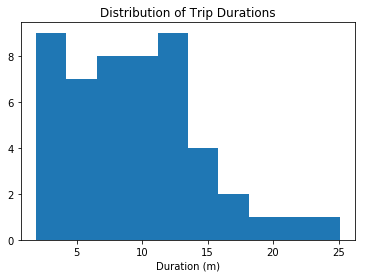

In [31]:
# load library
import matplotlib.pyplot as plt

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

You will now use these functions to create a histogram of the trip times for the city you selected in question 4c. Don't separate the Subscribers and Customers for now: just collect all of the trip times and plot them.

City:NYC


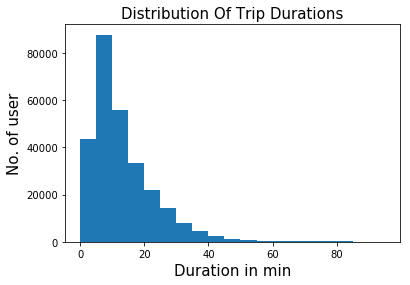

In [32]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##

def plot_histogram(filename):
    """ This  functiion will return a list 
         which conatins all different time duration of trip of a city
    """     
    with open(filename,'r') as f_in:
        trip_reader = csv.DictReader(f_in)
        trip_time = [] # It contains all trips time(min) of a city
        for row in trip_reader:
            trip_time.append( float(row['duration']))
    return trip_time

data_file = './data/NYC-2016-Summary.csv'

city = data_file.split('-')[0].split('/')[-1]
print('City:' + city)
trip_time =  plot_histogram(data_file)
bins = range(0,100,5)
plt.hist(trip_time,bins)
plt.title('Distribution Of Trip Durations',size = 15)
plt.xlabel('Duration in min',size = 15)
plt.ylabel('No. of user',size = 15)
plt.show()




If you followed the use of the `.hist()` and `.show()` functions exactly like in the example, you're probably looking at a plot that's completely unexpected. The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Take a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, you will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**Question 5**: Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in your selected city. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

**Answer**:The peak for Subscriber trip duration is 5-10 min.
           The peak for Customer trip duration is  20-25 min.
           The shape of distribution in the case of subscriber is right skewed.
           The shape of distribution in the case of customer is similar to normal distribution but not completely 
           

City:NYC


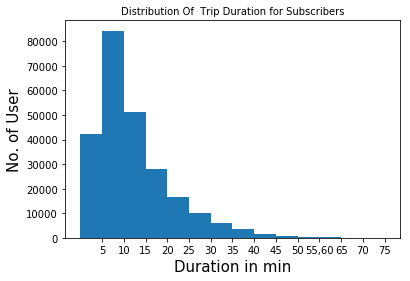

In [33]:
## Use this and additional cells to answer Question 5. ##
def plot_histogram(filename):
    """ This  functiion will return a list 
         which conatins all different time duration  trip fro subscribers of a city
    """     
    with open(filename,'r') as f_in:
        trip_reader = csv.DictReader(f_in)
        trip_time = [] # It contains all trips time(min) of a city
        for row in trip_reader:
            duration = float(row['duration'])
            if row['user_type'] == 'Subscriber' and duration < 75: # Adding limit to plot (trip duration < 75) 
                trip_time.append(duration)
                
    return trip_time

data_file = './data/NYC-2016-Summary.csv'

city = data_file.split('-')[0].split('/')[-1]
print('City:'+ city)
trip_time =  plot_histogram(data_file)

bins = range(0,75,5)
location = range(5,75,5)
labels = ['5','10','15','20','25','30','35','40','45','50','55,''60','65','70','75']
plt.xticks(location,labels)
plt.hist(trip_time,bins)
plt.title('Distribution Of  Trip Duration for Subscribers',size = 10)
plt.xlabel('Duration in min',size = 15)
plt.ylabel('No. of User',size = 15)
plt.show()


City:NYC


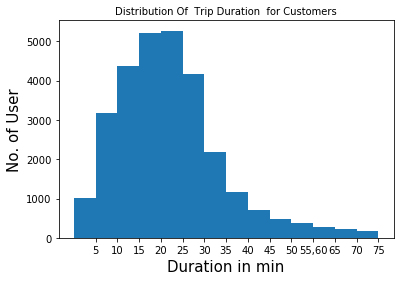

In [34]:
def plot_histogram(filename):
    """ This  functiion will return a list 
         which conatins all different time duration  trip for Customers of a city
    """     
    with open(filename,'r') as f_in:
        trip_reader = csv.DictReader(f_in)
        trip_time = [] # It contains all trips time(min) of a city
        
        for row in trip_reader :
            duration = float(row['duration'])
            if row['user_type'] == 'Customer' and duration < 75: # Adding limit to plot (trip duration < 75) :
                trip_time.append(duration)
    return trip_time

data_file = './data/NYC-2016-Summary.csv'

city = data_file.split('-')[0].split('/')[-1]
print('City:' + city)
trip_time =plot_histogram(data_file)
bins = range(0,75,5)
location = range(5,75,5)
plt.hist(trip_time,bins)
labels = ['5','10','15','20','25','30','35','40','45','50','55,''60','65','70','75']
plt.xticks(location,labels)

plt.title('Distribution Of  Trip Duration  for Customers',size = 10)
plt.xlabel('Duration in min',size = 15)
plt.ylabel('No. of User',size = 15)
plt.show()


<a id='eda_continued'></a>
## Performing Your Own Analysis

So far, you've performed an initial exploration into the data available. You have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, you have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now it is your turn to continue the exploration in a direction that you choose. Here are a few suggestions for questions to explore:

- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

If any of the questions you posed in your answer to question 1 align with the bullet points above, this is a good opportunity to investigate one of them. As part of your investigation, you will need to create a visualization. If you want to create something other than a histogram, then you might want to consult the [Pyplot documentation](https://matplotlib.org/devdocs/api/pyplot_summary.html). In particular, if you are plotting values across a categorical variable (e.g. city, user type), a bar chart will be useful. The [documentation page for `.bar()`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar) includes links at the bottom of the page with examples for you to build off of for your own use.

**Question 6**: Continue the investigation by exploring another question that could be answered by the data available. Document the question you want to explore below. Your investigation should involve at least two variables and should compare at least two groups. You should also use at least one visualization as part of your explorations.

**Answer**: QUES_1.How many Customers and Subscribers are present in those cities .plot Bar Graph?
            QUES_2.Find the day on which maximum user went on trip and no. of user on that day in each city .plot bar Graph?
  

In [36]:
## Use this and additional cells to continue to explore the dataset. ##
## Once you have performed your exploration, document your findings  ##
## in the Markdown cell above.                                       ##
def comp_usertype_city(filename):
    """
        Number Of different users will be counted for a city and return it
    """   
    
    with open(filename) as f_in:
        trip_reader = csv.DictReader(f_in)
        
        sub_total = 0 # total number of subscribers in a city
        cus_total = 0 # total number of customers in a city
        for row in trip_reader:
            if row['user_type'] =='Subscriber':
                sub_total +=1
            elif row['user_type'] == 'Customer':
                cus_total +=1
                
    return (sub_total,cus_total)        


City_name:Subscriber,Customer
{'Washington': (51753, 14573), 'Chicago': (54982, 17149), 'NYC': (245896, 30185)}


Subscribers:[51753, 54982, 245896]
Customers:[14573, 17149, 30185]


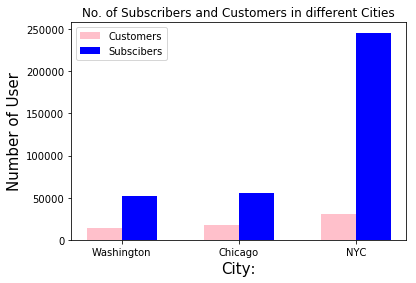

In [37]:
data_file = ['./data/Washington-2016-Summary.csv', './data/Chicago-2016-Summary.csv', './data/NYC-2016-Summary.csv']

dict_city = {} # It contain cities name with their different kind of user 

for datafile in data_file:
    city = datafile.split('-')[0].split('/')[-1]
    dict_city[city] = comp_usertype_city(datafile)
    
print('City_name:Subscriber,Customer')
print(dict_city)

cities = []         #it contains all cities
cities_subs = []    #it contains no. of Subscribers of each city
cities_cus = []     #it contains no. of Customers of each city
for key in dict_city:
    cities.append(key)
    cities_subs.append(dict_city[key][0])
    cities_cus.append(dict_city[key][1])
    
print('\n')
print('Subscribers:' + str(cities_subs))
print('Customers:' + str(cities_cus))
x_axis =np.arange(len(cities_subs))

plt.bar(x_axis,cities_cus,label = 'Customers',width=0.3, color = 'pink' )
plt.bar(x_axis + 0.3,cities_subs,label = 'Subscibers',width=0.3, color = 'b' )

plt.title('No. of Subscribers and Customers in different Cities')
plt.xlabel('City:',size = '15')
plt.ylabel('Number of User',size = 15)
plt.xticks(x_axis + 0.15,cities)
plt.legend()
plt.show()


In [38]:
from statistics import mode

def comp_week_day_city(filename):
    """
        This function returns name of day in which trip is taking the most by user and
        number of trip too in a  city
    """   
    with open(filename) as f_in:
        trip_reader = csv.DictReader(f_in)

        trip = [] # it contains all days that is equal to number of trip in a city
        for row in trip_reader:
            trip.append(row['day_of_week'])
            
  
        max_day = mode(trip) # max_day contains day in which most trip is taken by user in a city
        max_day_count = trip.count(max_day) # total number of trip on that day
        
    return (max_day,max_day_count)

{'Washington': ('Wednesday', 10103), 'Chicago': ('Monday', 11286), 'NYC': ('Wednesday', 44629)}


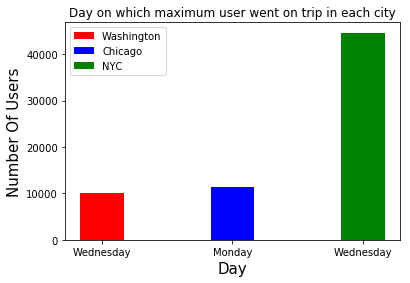

In [39]:

data_file = ['./data/Washington-2016-Summary.csv', './data/Chicago-2016-Summary.csv', './data/NYC-2016-Summary.csv']

dict_city = {} # It contain cities name with their different kind of user 

for datafile in data_file:
    city = datafile.split('-')[0].split('/')[-1]
    dict_city[city] = comp_week_day_city(datafile)

print(dict_city)

location = [] 
for key in dict_city:
    location.append(dict_city[key][0])
    
ind = np.arange(1.5,5,1.5)    

plt.bar(1.5,dict_city['Washington'][1],color = 'r',label = 'Washington',width = 0.5)
plt.bar(3,dict_city['Chicago'][1],color = 'b',label = 'Chicago',width = 0.5)
plt.bar(4.5,dict_city['NYC'][1],color = 'g',label = 'NYC',width = 0.5)
plt.title('Day on which maximum user went on trip in each city',)
plt.xlabel('Day',size = 15)
plt.ylabel('Number Of Users', size =15)
plt.xticks(ind,location)
plt.legend()
plt.show()


<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, you might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

**Question 7**: Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**:I would like to be able to apply the techniques of data science in stock market analysis,weather forecast.
            I would like to be able to learn a better approach of analysis to data in very efficient way and good concept.


In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0